# SEC Report 8-K Analysis of Filing Delays

Date: 2022-05-17  
Author: Jason Beach  
Categories: Data_Science
Tags: nlp, finance

<!--eofm-->

This analysis will investigate when SEC filings are made with respect to differences between earnings calls and associated quarterly filings for holding companies.  Questions analyzed include:

* What is the distribution between earnings and quarterly filings?
* Does this distribution change based on firm characteristics, such as size?
* Has this changed over time?  
* Did events such as CECL have an effect?

Through careful visual analysis we conclude that the difference (lag) between earnings and quarterly statement is consistent across time.  Some firms appear more consistent than others, also.  One particular bank characteristic is that having more assets under management usually increases the time between these two submissions.

One important take-away is that more than half of the earnings will be submitted greater than 100 days before the quarterly statement.

## Preparation

### Prepare environment

Load the appropriate modules.  Using a vm with a kernel can help in managing dependencies.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
import re
from rapidfuzz import process, fuzz

In [3]:
import requests
from bs4 import BeautifulSoup

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
root = Path('/home/jovyan/NOTEBOOK_PUBLIC')
libs = root / 'python_modules'

In [6]:
libs_downloader = libs / 'sec-edgar-downloader'
libs_extract = libs / 'sec-edgar-extract'
libs_workflow = libs / 'Prj-sec_workflows'

<br>

Changes to these files can be used, immediately - no need to reload!

In [7]:
os.chdir(libs_downloader)
from sec_edgar_downloader import Downloader
from sec_edgar_downloader import UrlComponent as uc
from sec_edgar_downloader import FilingStorage as fs
os.chdir(root)

In [8]:
os.chdir(libs_extract)
from sec_edgar_extractor.extract import Extractor, Doc
from sec_edgar_extractor import utils as ex_utils
os.chdir(root)

In [9]:
os.chdir(libs_workflow )
from sec_workflows import utils as wf_utils
os.chdir(root)

### Configuration

We configure the banks that are In or Out of scope, including their Ticker, CIK, and Assets under management for ease of use.

In [299]:
us_banks = [
{'Name': 'US Bankcorp', 'Ticker':'USB', 'CIK':'36104', 'Scope':'In', 'Assets': 556810647},
{'Name': 'American Express Company' , 'Ticker':'AXP', 'CIK':'4962', 'Scope':'In', 'Assets': 188548000},
{'Name': 'Capital One Financial Corporation', 'Ticker':'COF', 'CIK':'927628', 'Scope':'In', 'Assets': 372048692},
{'Name': 'Fifth Third Bancorp', 'Ticker':'FITB', 'CIK':'35527', 'Scope':'In', 'Assets': 206377146},
{'Name': 'Huntington Bancshares Incorporated', 'Ticker':'HBAN', 'CIK':'49196', 'Scope':'In', 'Assets': 173438393},
{'Name': 'Keycorp', 'Ticker':'KEY', 'CIK':'91576', 'Scope':'In', 'Assets': 184659457},
{'Name': 'Morgan Stanley', 'Ticker':'MS', 'CIK':'895421', 'Scope':'In', 'Assets': 177797000},
{'Name': 'JPMorgan Chase', 'Ticker':'JPM', 'CIK':'19617', 'Scope':'In', 'Assets': 3290398000},
{'Name': 'Citigroup Inc', 'Ticker':'C', 'CIK':'831001', 'Scope':'In', 'Assets': 2291413000},
{'Name': 'Wells Fargo', 'Ticker':'WFC', 'CIK':'72971', 'Scope':'In', 'Assets': 1786611000},
{'Name': 'Bank of America', 'Ticker':'BAC', 'CIK':'70858', 'Scope':'In', 'Assets': 2400819000},
{'Name': 'PNC Bank', 'Ticker':'PNC', 'CIK':'713676', 'Scope':'In', 'Assets': 462385600},
{'Name': 'Goldman Sachs', 'Ticker':'GS', 'CIK':'886982', 'Scope':'Out', 'Assets': 1349150000},
{'Name': 'Truist Financial Corporation', 'Ticker':'TFC', 'CIK':'92230', 'Scope':'Out', 'Assets': 528510000},
{'Name': 'Ally Financial Inc', 'Ticker':'ALLY', 'CIK':'40729', 'Scope':'Out', 'Assets': 182200000},
{'Name': 'Citizens Financial Group', 'Ticker':'CFG', 'CIK':'759944', 'Scope':'In', 'Assets': 187103189},
{'Name': 'BankUnited', 'Ticker':'BKU', 'CIK':'1504008', 'Scope':'Out', 'Assets': 35183055}
]

In [300]:
us_banks.sort(key=lambda bank: bank['Assets'], reverse=True)

In [325]:
#print(us_banks)

In [11]:
bank_list = [uc.Firm(ticker=bank['Ticker']) for bank in us_banks]

In [30]:
ciks = [firm.get_info('cik').__str__() for firm in bank_list]

In [13]:
dl = Downloader("/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/Earnings")

log: updated filing storage
log: created file for storing Filings list


In [14]:
dl.filing_storage

FilingStorage with 0 filing records

### Data ingest

Only the Filings' metadata is needed for this analysis.  We are concerned with when the filing is submitted and the period it covers.

In [ ]:
#get urls and download the docs
for bank in bank_list:
    TICKER = bank.get_info()['ticker']
    urls_8k = dl.get_metadata("8-K",
                       TICKER, 
                       after="2018-01-01"
                      )    

In [ ]:
for bank in bank_list:
    TICKER = bank.get_info()['ticker']
    urls_10k = dl.get_metadata("10-K",
                       TICKER, 
                       after="2018-01-01"
                      )    

In [ ]:
for bank in bank_list:
    TICKER = bank.get_info()['ticker']
    urls_10q = dl.get_metadata("10-Q",
                       TICKER, 
                       after="2018-01-01"
                      )    

There are 3,648 filings for the target banks, within this five year time period.  There are almost 500k documents for these filings, but they will not be needed.

In [237]:
dl.filing_storage

FilingStorage with 3648 filing records

In [238]:
df = dl.filing_storage.get_dataframe(mode='document')
df.shape

(49958, 14)

### General distribution of lags

8-K earnings releases are not directly associated with 10-K/-Q quarterly reports.  There may be multiple 8-Ks submitted for a quarterly period, and multiple earnings releases within those 8-Ks, also.

We use the most direct method of associating earnings with a particular quarter by using the following rules:

* find the quarter period for which the earnings release is submitted
* take the earliest earnings release, if there are multiple filings
* match this with the associated quarterly statement

In [264]:
tmp = dl.filing_storage.get_dataframe(mode='document')
df = tmp[tmp['short_cik'].isin(ciks)]
df['year'] = df['report_date'].dt.year
df['month'] = df['report_date'].dt.month
df.shape

(33547, 16)

This is the quarterly dataframe.

In [265]:
tmp = df[(df['file_type'].isin(['10-K','10-Q']))]
df_10q = tmp.drop_duplicates(subset=['accession_number']).reset_index()
df_10q.shape

(305, 17)

In [269]:
df_10q['qtr'] = 0
df_10q['qtr'][df_10q['month'] <= 12] = 4
df_10q['qtr'][df_10q['month'] < 10] = 3
df_10q['qtr'][df_10q['month'] < 7] = 2
df_10q['qtr'][df_10q['month'] < 4] = 1

In [270]:
df_10q['dt_filed'] = pd.to_datetime(df_10q['file_date'])
df_10q['yr-qtr'] = df_10q.apply(lambda row: str(row['year']) + '-' + str(row['qtr']) , axis=1)

In [267]:
#df_10q['yr-qtr'].value_counts()
#df_10q[['short_cik', 'yr-qtr', 'report_date', 'file_date']]

This is the earnings dataframe.

In [271]:
tmp = df[(df['file_type'].isin(['8-K'])) & (df['Type'].isin(['EX-99.1','EX-99.2','EX-99.3'])) ]
df_8k = tmp.drop_duplicates(subset=['accession_number']).reset_index()
df_8k['qtr'] = df_8k['report_date'].dt.quarter
df_8k.shape

(855, 18)

In [272]:
df_8k['dt_file_date'] = pd.to_datetime(df_8k['file_date'])
df_8k['yr-qtr'] = df_8k.apply(lambda row: str(row['year']) + '-' + str(row['qtr']) , axis=1)

In [273]:
df_8k.columns

Index(['index', 'Seq', 'Description', 'Document', 'Type', 'Size', 'URL',
       'Extension', 'FS_Location', 'short_cik', 'accession_number',
       'file_type', 'file_date', 'report_date', 'yr-month', 'year', 'month',
       'qtr', 'dt_file_date', 'yr-qtr'],
      dtype='object')

This may be the best method.

In [274]:
tmp = df_8k.sort_values(by=['dt_file_date'], ascending=True).groupby(['short_cik','yr-qtr'])['dt_file_date'].first()
df_8k = pd.DataFrame(tmp)
df_8k.shape[0]

306

In [113]:
#df_8k['qtr'].value_counts()

This is a complex method for associating the earnings with the quarterly, and the above simpler approach is probably more accurate.  

There is no way to distinguish what quarter the 8-Ks earnings reference, without evaluating every value in the report.  Instead, assume that 8-Ks will be submitted before a subsequent 10-Q, then associate that 10-Q's submitted quarter with the 8-K.

def get_8k_qtr(df8k, df10q):
    """Get the 8-K quarter by referencing the correspoding 10-Qs.
    
    There is a change, below, to use the 10q report_data for filtering.
    """
    #prepare
    df8k['dt_file_date'] = pd.to_datetime(df_8k['file_date'])
    df10q['dt_filed'] = pd.to_datetime(df10q['report_date'])
    df8k.sort_values(by=['short_cik','dt_file_date'], inplace=True)
    df10q.sort_values(by=['short_cik','dt_filed'], inplace=True)
    ciks10q = df10q['short_cik'].tolist()
    
    #check each filing
    results = []
    for doc in df8k.to_dict('records'):
        cik = doc['short_cik'] 
        fd = doc['dt_file_date']
        if cik in ciks10q:
            dftmp = df10q[(df10q['short_cik'] == cik) & (df10q['dt_filed'] >= fd)]
            if dftmp.shape[0] > 0:
                item = dftmp.iloc[0]['yr-qtr']
                results.append( item )
            else: results.append( None )
        else: results.append( None )
    df_8k['yr-qtr'] = results    
    return df_8k
    
new_df_8k = get_8k_qtr(df_8k, df_10q)

<br>

Now, merge the 8-K and corresponding 10-Q for the quarter, then find the difference in filing dates.

In [275]:
df_mrg = pd.merge(df_8k, df_10q,  how='left', left_on=['short_cik','yr-qtr'], right_on = ['short_cik','yr-qtr'])
df_mrg['diff'] = df_mrg['dt_filed'] - df_mrg['dt_file_date'] 
df_mrg['diff_days'] = df_mrg['diff'].map(lambda x: x.days)
df_mrg2 = df_mrg[df_mrg['diff_days'].isnull()==False]

In [276]:
df_mrg2[['short_cik', 'yr-qtr', 'dt_filed', 'dt_file_date', 'diff_days']]

,short_cik,yr-qtr,dt_filed,dt_file_date,diff_days
0,1504008,2018-1,2018-05-08,2018-01-23,105.0
1,1504008,2018-2,2018-08-07,2018-04-25,104.0
2,1504008,2018-3,2018-11-06,2018-07-24,105.0
3,1504008,2018-4,2019-02-27,2018-10-24,126.0
4,1504008,2019-1,2019-05-07,2019-01-23,104.0
...,...,...,...,...,...
300,927628,2021-1,2021-05-07,2021-01-26,101.0
301,927628,2021-2,2021-07-30,2021-04-27,94.0
302,927628,2021-3,2021-11-05,2021-07-22,106.0
303,927628,2021-4,2022-02-25,2021-10-18,130.0


## Analysis

Remove outliers as determined by visual inspection.

In [284]:
df_mrg3 = df_mrg2[df_mrg2['diff_days']>60]
df_mrg3.shape[0]

287

Get the basic distribution between filing dates.

In [278]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

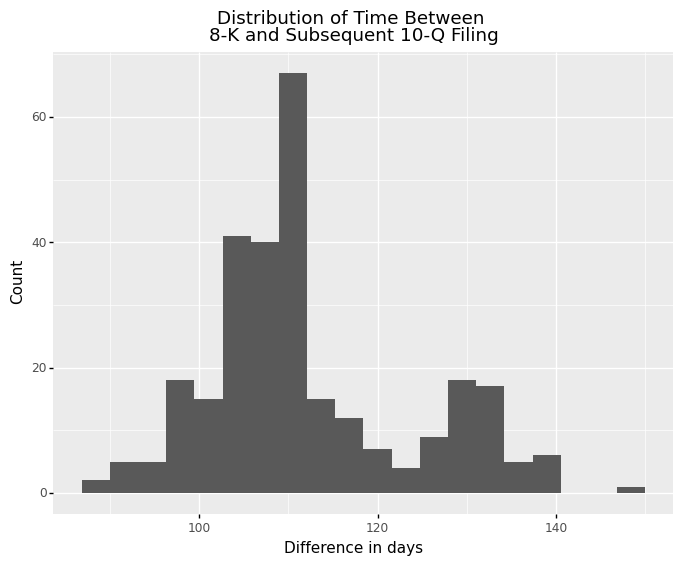

<ggplot: (8752830669653)>

In [285]:
(ggplot(df_mrg3, aes(x='diff_days', y=after_stat('count')))
    + geom_histogram(bins=20)
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='File Type')
    #+ scale_x_log10()
    + theme(figure_size=(8, 6))
)

<br>

Finally, interrogate the difference distribution by graphing and summary statistics.

In [286]:
#basic
diff = df_mrg3['diff_days'].to_list()
print(f"Mean: {np.mean(diff) }")
print(f"Median: {np.median(diff) }")

Mean: 112.07665505226481
Median: 110.0


This method uses the estimated densities to determine expected lags between associated submissions.  We calculate more than half of the earnings will be submitted greater than 100 days before the quarterly statement.

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [340]:
data = diff
count, bins_count = np.histogram(data, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
print(f"About {round((1-cdf[10])*100,2) }% of these 8-Ks")
print(f"will be filed more than {bins_count[10]} days before the 10-Q")

About 56.1% of these 8-Ks
will be filed more than 107.0 days before the 10-Q


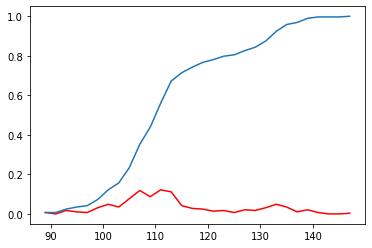

In [289]:
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")

### Changes in distribution over time

The following graphs are an attempt to visualy distinguish changes in lags over the last five years.  The first combines data, annually, the second displays it by quarter.

Of particular interest is whether the implementation of CECL, at the end of 2019, affected the lag.  This does not appear to be the case, but a closer examination using change-point analysis may provide more insight.

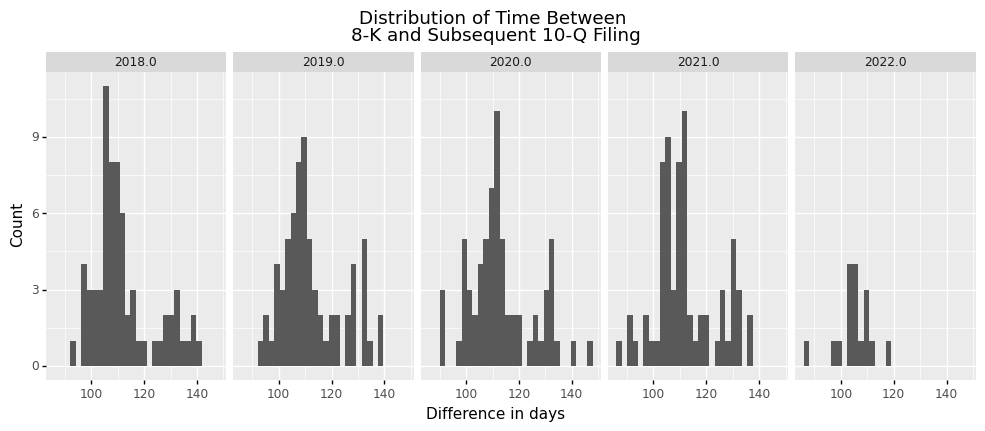

<ggplot: (8752830188749)>

In [291]:
(ggplot(df_mrg3, aes(x='diff_days', y=after_stat('count')))
    + geom_histogram(bins=30)
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='File Type')
    #+ scale_x_log10()
    + theme(figure_size=(8, 6))
    + facet_wrap('year', ncol=5)
    + theme(figure_size=(12, 4))
)

This perspective groups the quarters by columns, which can provide insight to seasonal cycles.

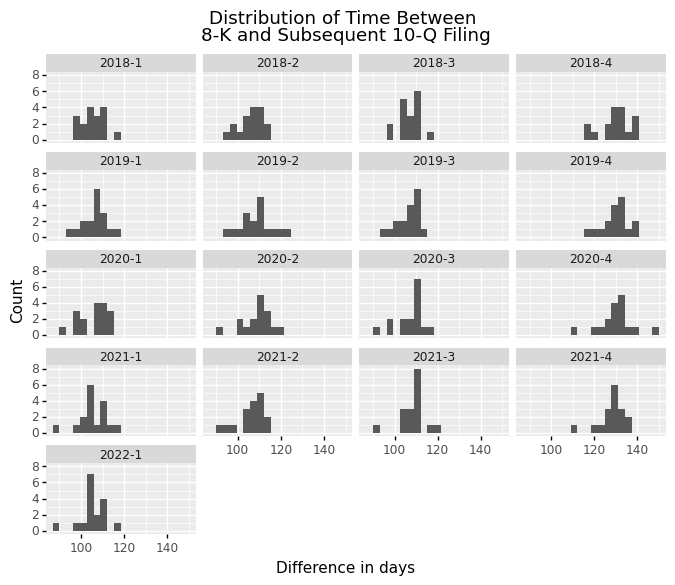

<ggplot: (8752834899782)>

In [330]:
(ggplot(df_mrg3, aes(x='diff_days', y=after_stat('count')))
    + geom_histogram(bins=20)
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='File Type')
    #+ scale_x_log10()
    + facet_wrap('yr-qtr', ncol=4)
    + theme(figure_size=(8, 6))
)

### Differences in lag by bank

Looking into lags for each bank may give clues to individual performance.  The graph below indicates some banks have similar lags across time, indicated by a long bar of the count in Difference in days.  These banks include, CFG, JPM, Key, MS, and PNC.  

Other banks are fairly inconsistent in submitting the quarterly, such as ALLY with submissions from 100 to 140 days difference.

In [321]:
df_banks = pd.DataFrame(us_banks)
df_banks['CIK'] = df_banks['CIK'].astype(str)
df_mrg4 = pd.merge(df_mrg3, df_banks, how='left', left_on='short_cik', right_on='CIK')
df_mrg4['AssetRange'] = pd.cut(df_mrg4['Assets'], 4, labels=['medium','large-small', 'large-medium', 'large-big'])

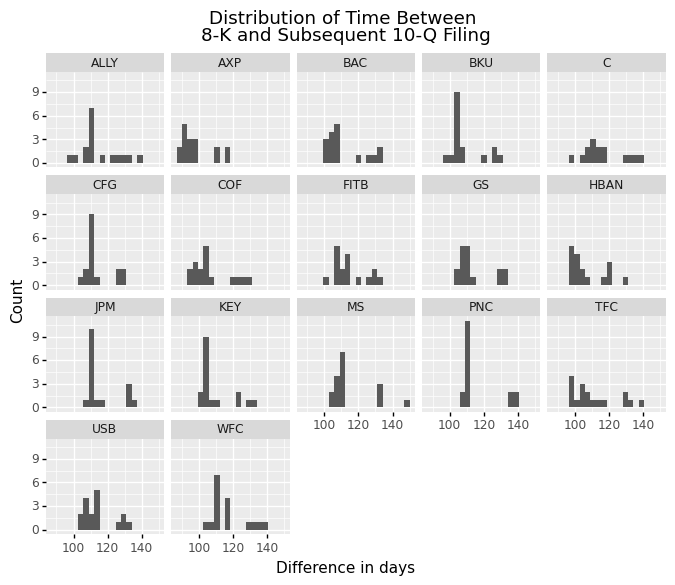

<ggplot: (8752838475017)>

In [334]:
(ggplot(df_mrg4, aes(x='diff_days', y=after_stat('count')))
    + geom_histogram(bins=20)
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='File Type')
    #+ scale_x_log10()
    + facet_wrap('Ticker')
    + theme(figure_size=(8, 6))
)

The following distribution is color-filled by the amount of the banks' assets under management, for medium and groups of large banks.  Interestingly, increasing assets appears to increase the difference in days, seen by the shift in brighter colors to the right.  

This probably makes sense as more assets may relate to increased difficulty in combining data for each quarterly statement.  A larger sampling of firms over time would lend credence to this hypothesis.

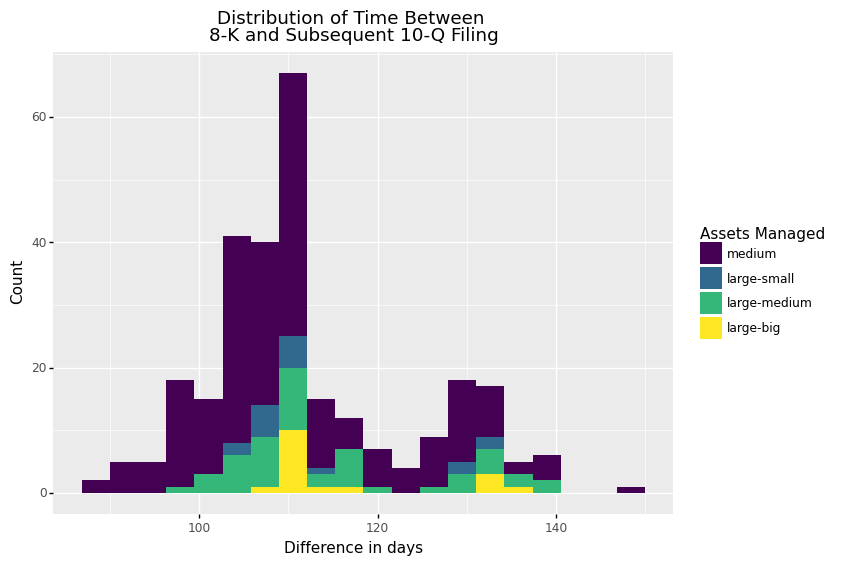

<ggplot: (8752831826221)>

In [324]:
(ggplot(df_mrg4, aes(x='diff_days', y=after_stat('count'), fill='AssetRange'))
    + geom_histogram(bins=20)
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='Assets Managed')
    #+ scale_x_log10()
    + theme(figure_size=(8, 6))
)